In [ ]:
Forecasting Methods

In [4]:
import os
import pandas as pd
import sqlite3
from google.cloud import bigquery
# Create BigQuery client
client = bigquery.Client(project="main-cocoa-308521")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
import seaborn as sns   # only for the heat‑map, optional
import glob
from pathlib import Path

Missing borough label for 0.00% of station‑days


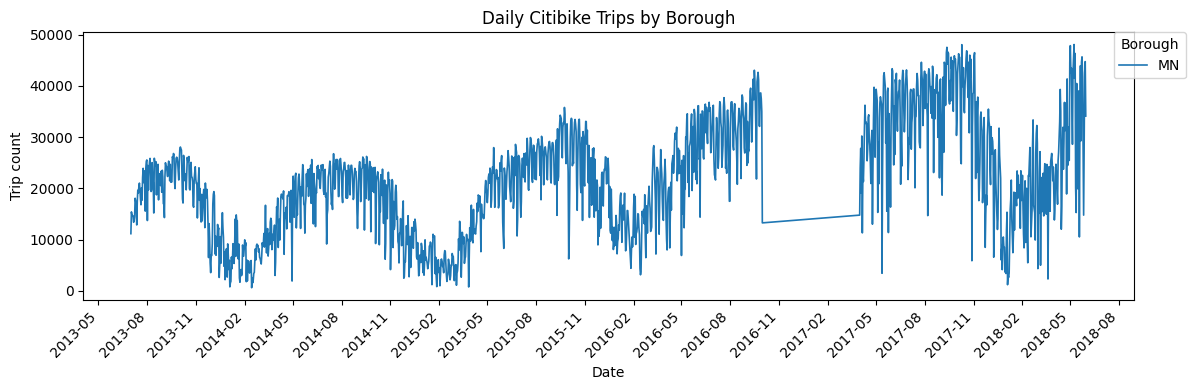

In [6]:
# 1) SQL with station_id included and no premature aggregation
query = """
WITH trips AS (
  SELECT
    t.start_station_id AS station_id,
    DATE(t.starttime)  AS trip_date
  FROM `bigquery-public-data.new_york_citibike.citibike_trips`   t
  JOIN `bigquery-public-data.new_york_citibike.citibike_stations` s
    ON t.start_station_name = s.name
  WHERE t.start_station_name IS NOT NULL
),
daily AS (
  SELECT
    station_id,
    trip_date,
    COUNT(*) AS trip_count
  FROM trips
  GROUP BY station_id, trip_date
),
cut AS (
  SELECT
    APPROX_QUANTILES(trip_count, 100)[OFFSET(33)] AS p33,
    APPROX_QUANTILES(trip_count, 100)[OFFSET(66)] AS p66
  FROM daily
)
SELECT
  station_id,
  trip_date,
  trip_count,
  CASE
    WHEN trip_count <= c.p33 THEN 'Low'
    WHEN trip_count <= c.p66 THEN 'Medium'
    ELSE 'High'
  END AS demand_category
FROM daily d
CROSS JOIN cut c
"""
results = client.query(query).result().to_dataframe()      # station_id is INT64 → convert below

# ────────────────────────────────────────────────────────────────
# 2) Read TSV (station_id as STRING)
# ────────────────────────────────────────────────────────────────
tsv_path = "citibike-stations-data-summary.tsv"

stations_boro = (
    pd.read_csv(tsv_path, sep="\t", dtype={'station_id': int})
      .loc[:, ['station_id', 'boro']]
      .drop_duplicates()
)

# ────────────────────────────────────────────────────────────────
# 3) Merge
# ────────────────────────────────────────────────────────────────
results['station_id'] = results['station_id'].astype(int)
merged = results.merge(stations_boro, on='station_id', how='left')

# quick sanity: any missing boroughs?
missing_pct = merged['boro'].isna().mean() * 100
print(f"Missing borough label for {missing_pct:.2f}% of station‑days")

# ────────────────────────────────────────────────────────────────
# 4) Aggregate trips by borough × day
# ────────────────────────────────────────────────────────────────
boro_daily = (
    merged
      .dropna(subset=['boro'])          # keep only labelled stations
      .groupby(['trip_date', 'boro'])['trip_count']
      .sum()
      .reset_index()
)

# pivot to wide for easy plotting
wide = (
    boro_daily
      .pivot(index='trip_date', columns='boro', values='trip_count')
      .fillna(0)
      .sort_index()
)

# ────────────────────────────────────────────────────────────────
# 5) Time‑series visualization
# ────────────────────────────────────────────────────────────────
plt.figure(figsize=(12,4))
wide['MN'].plot(ax=plt.gca(), linewidth=1.2)

plt.title("Daily Citibike Trips by Borough")
plt.ylabel("Trip count")
plt.xlabel("Date")

# nicer x‑axis ticks every 1 month
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y‑%m'))
plt.xticks(rotation=45, ha='right')

plt.legend(title='Borough', bbox_to_anchor=(1.05,1), borderaxespad=0)
plt.tight_layout()
plt.show()



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1965: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


Missing borough label for 0.00% of station‑days
First date: 2013-07-01  —  Last date: 2018-05-31  (1,796 daily points)
Train points: 235,  Test points: 22
Hold‑out MAPE: 24.83%
Hold‑out MAPE (gap‑aware): 24.83%


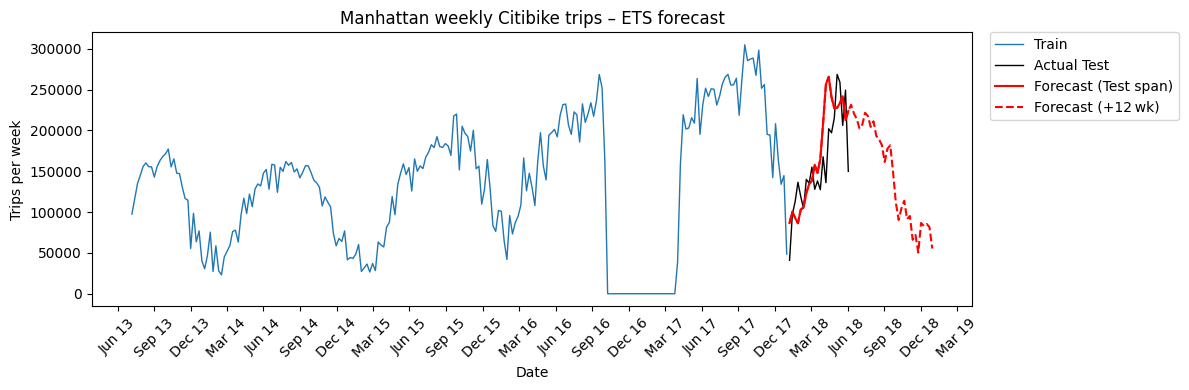

In [141]:
# 1) SQL with station_id included and no premature aggregation
query = """
WITH trips AS (
  SELECT
    t.start_station_id AS station_id,
    DATE(t.starttime)  AS trip_date
  FROM `bigquery-public-data.new_york_citibike.citibike_trips`   t
  JOIN `bigquery-public-data.new_york_citibike.citibike_stations` s
    ON t.start_station_name = s.name
  WHERE t.start_station_name IS NOT NULL
),
daily AS (
  SELECT
    station_id,
    trip_date,
    COUNT(*) AS trip_count
  FROM trips
  GROUP BY station_id, trip_date
),
cut AS (
  SELECT
    APPROX_QUANTILES(trip_count, 100)[OFFSET(33)] AS p33,
    APPROX_QUANTILES(trip_count, 100)[OFFSET(66)] AS p66
  FROM daily
)
SELECT
  station_id,
  trip_date,
  trip_count,
  CASE
    WHEN trip_count <= c.p33 THEN 'Low'
    WHEN trip_count <= c.p66 THEN 'Medium'
    ELSE 'High'
  END AS demand_category
FROM daily d
CROSS JOIN cut c
"""
results = client.query(query).result().to_dataframe()      # station_id is INT64 → convert below

# ────────────────────────────────────────────────────────────────
# 2) Read TSV (station_id as STRING)
# ────────────────────────────────────────────────────────────────
stations_boro = (
    pd.read_csv(tsv_path, sep="\t", dtype={'station_id': int})
      .loc[:, ['station_id', 'boro']]
      .drop_duplicates()
)

# ────────────────────────────────────────────────────────────────
# 3) Merge
# ────────────────────────────────────────────────────────────────
results['station_id'] = results['station_id'].astype(int)
merged = results.merge(stations_boro, on='station_id', how='left')

# quick sanity: any missing boroughs?
missing_pct = merged['boro'].isna().mean() * 100
print(f"Missing borough label for {missing_pct:.2f}% of station‑days")

# ────────────────────────────────────────────────────────────────
# 4) Aggregate trips by borough × day
# ────────────────────────────────────────────────────────────────
boro_daily = (
    merged
      .dropna(subset=['boro'])          # keep only labelled stations
      .groupby(['trip_date', 'boro'])['trip_count']
      .sum()
      .reset_index()
)

# pivot to wide for easy plotting
wide = (
    boro_daily
      .pivot(index='trip_date', columns='boro', values='trip_count')
      .fillna(0)
      .sort_index()
)

# ────────────────────────────────────────────────────────────────
# 1) extract MN series  (use the `wide` DataFrame created earlier)
# ────────────────────────────────────────────────────────────────
mn_daily = (
    wide['MN']                 # Series, index = date
        .asfreq('D')           # force explicit daily index
        .fillna(0)             # Citibike rarely has NA, but be safe
)

# quick sanity
print(f"First date: {mn_daily.index.min().date()}  —  "
      f"Last date: {mn_daily.index.max().date()}  "
      f"({len(mn_daily):,} daily points)")

# ────────────────────────────────────────────────────────────────
# 2) aggregate to weekly totals  (Saturday‑to‑Friday by default)
#    -> smoother, seasonality period = 52 weeks
# ────────────────────────────────────────────────────────────────
mn_weekly = mn_daily.resample('W').sum()

# ────────────────────────────────────────────────────────────────
# 3) simple train / test split
#    use everything up to 2023‑12‑31 for training, forecast 2024+
# ────────────────────────────────────────────────────────────────
split_date = '2018-01-01'
train = mn_weekly.loc[: split_date]
test  = mn_weekly.loc[split_date :]

print(f"Train points: {len(train)},  Test points: {len(test)}")

# ────────────────────────────────────────────────────────────────
# 4) fit ETS (additive trend, additive weekly seasonality)
#    weekly series → seasonality period = 52
# ────────────────────────────────────────────────────────────────
model = ExponentialSmoothing(
            train,
            trend='add',
            seasonal='add',
            seasonal_periods=52,
            initialization_method='estimated'
        ).fit(optimized=True)

ets = ETSModel(
        train,
        trend='add',
        seasonal='add',
        seasonal_periods=52,
        damped_trend=False,
        missing='drop'          # <<< key line: drops NaNs internally
)
fit = ets.fit()

# ────────────────────────────────────────────────────────────────
# 5) forecast the test span + 12 future weeks
# ────────────────────────────────────────────────────────────────
test_non_na = test.dropna()
fh_test   = len(test_non_na)
fh_future = 52          # change if you want a different horizon

pred_test   = fit.forecast(fh_test).rename('forecast_test')
pred_future = fit.forecast(fh_future).rename('forecast_future')

# evaluation on the hold‑out period
mape = mean_absolute_percentage_error(test, pred_test) * 100
print(f"Hold‑out MAPE: {mape:.2f}%")

# evaluate only where we truly have both y_true and y_pred
if fh_test > 0:
    mape = mean_absolute_percentage_error(test_non_na, pred_test) * 100
    print(f"Hold‑out MAPE (gap‑aware): {mape:.2f}%")
else:
    print("No non‑missing weeks in the test slice; skipping MAPE.")

# ────────────────────────────────────────────────────────────────
# 6) plot
# ────────────────────────────────────────────────────────────────
plt.figure(figsize=(12,4))
plt.plot(train,  label='Train',  linewidth=1)
plt.plot(test,   label='Actual Test', color='black', linewidth=1)
plt.plot(pred_test,   label='Forecast (Test span)', color='red')
plt.plot(pred_future, label='Forecast (+12 wk)',   color='red', linestyle='--')

plt.title("Manhattan weekly Citibike trips – ETS forecast")
plt.ylabel("Trips per week")
plt.xlabel("Date")

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))
plt.xticks(rotation=45)

plt.legend(bbox_to_anchor=(1.02,1), borderaxespad=0)
plt.tight_layout()
plt.show()



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1965: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


Missing borough label for 0.00% of station‑days
First date: 2013-07-01  —  Last date: 2018-05-31  (1,796 daily points)
Train points: 235,  Test points: 22


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Hold‑out MAPE: 31.24%


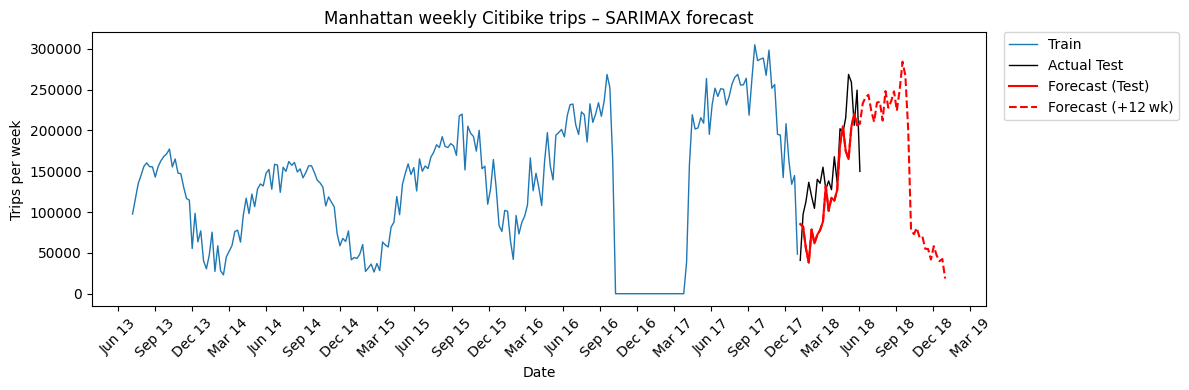

In [13]:
# 1) SQL with station_id included and no premature aggregation
query = """
WITH trips AS (
  SELECT
    t.start_station_id AS station_id,
    DATE(t.starttime)  AS trip_date
  FROM `bigquery-public-data.new_york_citibike.citibike_trips`   t
  JOIN `bigquery-public-data.new_york_citibike.citibike_stations` s
    ON t.start_station_name = s.name
  WHERE t.start_station_name IS NOT NULL
),
daily AS (
  SELECT
    station_id,
    trip_date,
    COUNT(*) AS trip_count
  FROM trips
  GROUP BY station_id, trip_date
),
cut AS (
  SELECT
    APPROX_QUANTILES(trip_count, 100)[OFFSET(33)] AS p33,
    APPROX_QUANTILES(trip_count, 100)[OFFSET(66)] AS p66
  FROM daily
)
SELECT
  station_id,
  trip_date,
  trip_count,
  CASE
    WHEN trip_count <= c.p33 THEN 'Low'
    WHEN trip_count <= c.p66 THEN 'Medium'
    ELSE 'High'
  END AS demand_category
FROM daily d
CROSS JOIN cut c
"""
results = client.query(query).result().to_dataframe()      # station_id is INT64 → convert below

# ────────────────────────────────────────────────────────────────
# 2) Read TSV (station_id as STRING)
# ────────────────────────────────────────────────────────────────
stations_boro = (
    pd.read_csv(tsv_path, sep="\t", dtype={'station_id': int})
      .loc[:, ['station_id', 'boro']]
      .drop_duplicates()
)

# ────────────────────────────────────────────────────────────────
# 3) Merge
# ────────────────────────────────────────────────────────────────
results['station_id'] = results['station_id'].astype(int)
merged = results.merge(stations_boro, on='station_id', how='left')

# quick sanity: any missing boroughs?
missing_pct = merged['boro'].isna().mean() * 100
print(f"Missing borough label for {missing_pct:.2f}% of station‑days")

# ────────────────────────────────────────────────────────────────
# 4) Aggregate trips by borough × day
# ────────────────────────────────────────────────────────────────
boro_daily = (
    merged
      .dropna(subset=['boro'])          # keep only labelled stations
      .groupby(['trip_date', 'boro'])['trip_count']
      .sum()
      .reset_index()
)

# pivot to wide for easy plotting
wide = (
    boro_daily
      .pivot(index='trip_date', columns='boro', values='trip_count')
      .fillna(0)
      .sort_index()
)

# ────────────────────────────────────────────────────────────────
# 1) extract MN series  (use the `wide` DataFrame created earlier)
# ────────────────────────────────────────────────────────────────
mn_daily = (
    wide['MN']                 # Series, index = date
        .asfreq('D')           # force explicit daily index
        .fillna(0)             # Citibike rarely has NA, but be safe
)

# quick sanity
print(f"First date: {mn_daily.index.min().date()}  —  "
      f"Last date: {mn_daily.index.max().date()}  "
      f"({len(mn_daily):,} daily points)")

# ────────────────────────────────────────────────────────────────
# 2) aggregate to weekly totals  (Saturday‑to‑Friday by default)
#    -> smoother, seasonality period = 52 weeks
# ────────────────────────────────────────────────────────────────
mn_weekly = mn_daily.resample('W').sum()

# ────────────────────────────────────────────────────────────────
# 3) simple train / test split
#    use everything up to 2023‑12‑31 for training, forecast 2024+
# ────────────────────────────────────────────────────────────────
split_date = '2018-01-01'
train = mn_weekly.loc[: split_date]
test  = mn_weekly.loc[split_date :]

print(f"Train points: {len(train)},  Test points: {len(test)}")

# ────────────────────────────────────────────────────────────────
# 4) fit ETS (additive trend, additive weekly seasonality)
#    weekly series → seasonality period = 52
# ────────────────────────────────────────────────────────────────
sarimax_model = SARIMAX(
    train,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 52),
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarimax_fit = sarimax_model.fit(disp=False)

# ────────────────────────────────────────────────────────────────
# 5) forecast the test span + future weeks
# ────────────────────────────────────────────────────────────────
# forecast the same length as your test slice
fh_test   = len(test.dropna())
fh_future = 52

# For the test period, align predictions to your test index
pred_test = sarimax_fit.get_prediction(
    start=test.index[0],
    end=test.index[0] + pd.offsets.Week(fh_test-1),
    dynamic=False
).predicted_mean.rename('forecast_test')

# For the future horizon, forecast forward
pred_future = sarimax_fit.get_forecast(
    steps=fh_future
).predicted_mean.rename('forecast_future')

# ────────────────────────────────────────────────────────────────
# 6) evaluate with MAPE
# ────────────────────────────────────────────────────────────────
test_non_na = test.dropna()
mape_test   = mean_absolute_percentage_error(test_non_na, pred_test.loc[test_non_na.index]) * 100
print(f"Hold‑out MAPE: {mape_test:.2f}%")

# ────────────────────────────────────────────────────────────────
# 7) plot
# ────────────────────────────────────────────────────────────────
plt.figure(figsize=(12,4))
plt.plot(train,             label='Train',             linewidth=1)
plt.plot(test,              label='Actual Test', color='black', linewidth=1)
plt.plot(pred_test,         label='Forecast (Test)',    color='red')
plt.plot(pred_future,       label='Forecast (+12 wk)',  color='red', linestyle='--')

plt.title("Manhattan weekly Citibike trips – SARIMAX forecast")
plt.ylabel("Trips per week")
plt.xlabel("Date")

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))
plt.xticks(rotation=45)

plt.legend(bbox_to_anchor=(1.02,1), borderaxespad=0)
plt.tight_layout()
plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1965: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(
/var/folders/nm/dc639mrx6s90bqg3vn0khw9c0000gn/T/ipykernel_85086/183494305.py:53: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .asfreq('H')              # make an explicit Hourly index


trip_hour
2013-07-01 00:00:00    141
2013-07-01 01:00:00     75
2013-07-01 02:00:00     49
2013-07-01 03:00:00     32
2013-07-01 04:00:00     32
Freq: h, Name: trip_count, dtype: Int64
Span: 2013-07-01 00:00:00 → 2018-05-31 23:00:00
Train hrs: 39,481  |  Test hrs: 3,624
Hold‑out MAPE: 1134522626934195584.00%


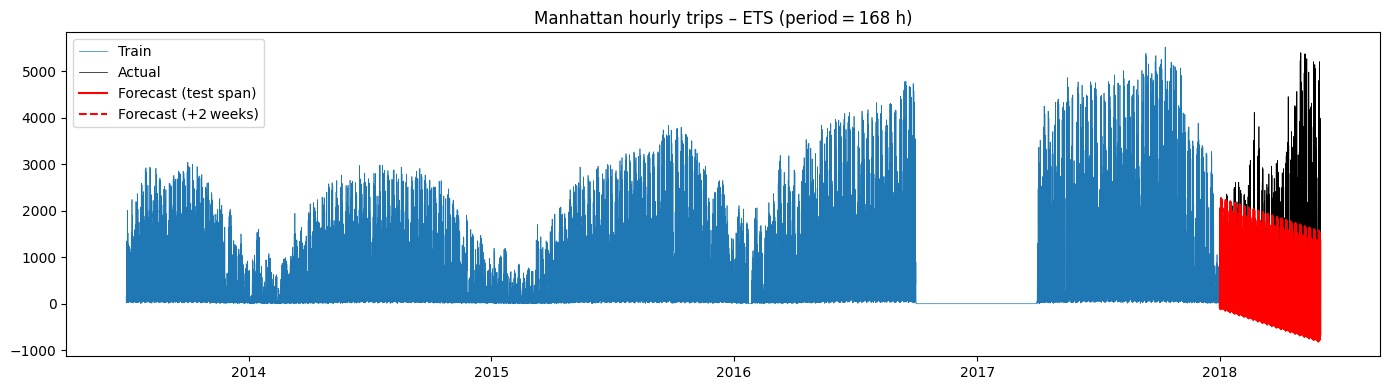

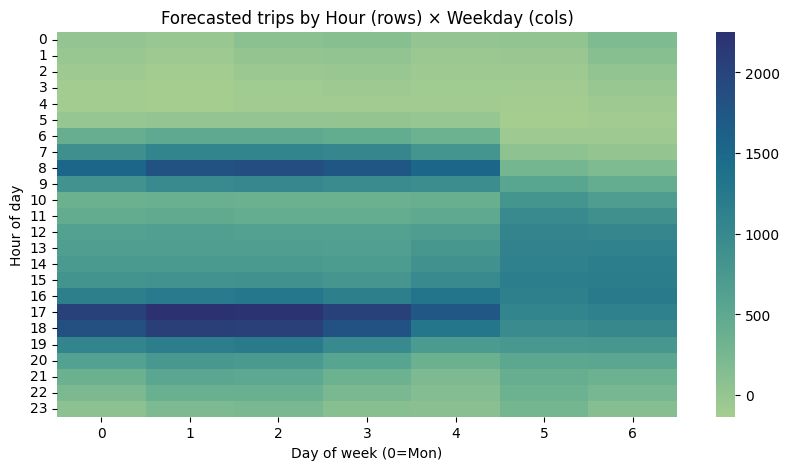

In [136]:
# 1) SQL with station_id included and no premature aggregation
hourly_sql = """
WITH trips AS (
  SELECT
    t.start_station_id AS station_id,
    DATETIME_TRUNC(t.starttime, HOUR) AS trip_hour
  FROM `bigquery-public-data.new_york_citibike.citibike_trips`   t
  JOIN `bigquery-public-data.new_york_citibike.citibike_stations` s
    ON t.start_station_name = s.name
  WHERE t.start_station_name IS NOT NULL
),
hourly AS (
  SELECT
    station_id,
    trip_hour,
    COUNT(*) AS trip_count
  FROM trips
  GROUP BY station_id, trip_hour
)

SELECT * FROM hourly
"""
hourly_df = client.query(hourly_sql).result().to_dataframe()     # station_id is INT64 → convert below
hourly_df['trip_hour'] = pd.to_datetime(hourly_df['trip_hour'])

# ────────────────────────────────────────────────────────────────
# 2) Read TSV (station_id as STRING)
# ────────────────────────────────────────────────────────────────
stations_boro = (
    pd.read_csv(tsv_path, sep="\t", dtype={'station_id': int})
      .loc[:, ['station_id', 'boro']]
      .drop_duplicates()
)

# ────────────────────────────────────────────────────────────────
# 3) Merge
# ────────────────────────────────────────────────────────────────
hourly_df['station_id'] = hourly_df['station_id'].astype(int)
hourly_boro = hourly_df.merge(stations_boro, on='station_id', how='left')

mn_hourly = (
    hourly_boro
      .query("boro == 'MN'")
      .groupby('trip_hour')['trip_count']
      .sum()
      .asfreq('H')              # make an explicit Hourly index
      .fillna(0)                # no rides → 0
      .sort_index()
)

print(mn_hourly.head())
print("Span:", mn_hourly.index.min(), "→", mn_hourly.index.max())

# ────────────────────────────────────────────────────────────────
# 4) Aggregate trips by borough × day
# ────────────────────────────────────────────────────────────────
boro_daily = (
    merged
      .dropna(subset=['boro'])          # keep only labelled stations
      .groupby(['trip_date', 'boro'])['trip_count']
      .sum()
      .reset_index()
)

# pivot to wide for easy plotting
wide = (
    boro_daily
      .pivot(index='trip_date', columns='boro', values='trip_count')
      .fillna(0)
      .sort_index()
)

split_ts = '2018-01-01 00:00'          # adjust as you like
train = mn_hourly.loc[: split_ts]
test  = mn_hourly.loc[split_ts :]

print(f"Train hrs: {len(train):,}  |  Test hrs: {len(test):,}")

# ────────────────────────────────────────────────────────────────
# 4) fit ETS (additive trend, additive weekly seasonality)
#    weekly series → seasonality period = 52
# ────────────────────────────────────────────────────────────────
seasonal_period = 24 * 7    # 168
hw_model = ExponentialSmoothing(
              train,
              trend='add',
              seasonal='add',
              seasonal_periods=seasonal_period,
              initialization_method='estimated'
          ).fit(optimized=True)

fh_test   = len(test)
fh_future = 24 * 7 * 2       # e.g. 2 weeks ahead

pred_test   = hw_model.forecast(fh_test).rename('forecast_test')
pred_future = hw_model.forecast(fh_future).rename('forecast_future')

mape = mean_absolute_percentage_error(test, pred_test) * 100
print(f"Hold‑out MAPE: {mape:.2f}%")

# ────────────────────────────────────────────────────────────────
# 6) plot
# ────────────────────────────────────────────────────────────────
# a) time‑series plot
plt.figure(figsize=(14,4))
plt.plot(train, label='Train', linewidth=0.5)
plt.plot(test,  label='Actual', color='black', linewidth=0.5)
plt.plot(pred_test,  label='Forecast (test span)', color='red')
plt.plot(pred_future, label='Forecast (+2 weeks)', color='red', ls='--')
plt.title("Manhattan hourly trips – ETS (period = 168 h)")
plt.legend(); plt.tight_layout(); plt.show()

# b) weekday × hour view of the new forecast
future = pred_future.to_frame('yhat')
future['dow']  = future.index.dayofweek      # 0=Mon
future['hour'] = future.index.hour
pivot = future.pivot_table(values='yhat', index='hour', columns='dow')

plt.figure(figsize=(10,5))
sns.heatmap(pivot, cmap='crest', annot=False)
plt.title("Forecasted trips by Hour (rows) × Weekday (cols)")
plt.xlabel("Day of week (0=Mon)"); plt.ylabel("Hour of day")
plt.show()



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1965: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


/Users/oscartran/Peek/201610-citibike-tripdata_1.csv
/Users/oscartran/Peek/201703-citibike-tripdata.csv_1.csv
/Users/oscartran/Peek/201610-citibike-tripdata_2.csv
/Users/oscartran/Peek/201702-citibike-tripdata.csv_1.csv
/Users/oscartran/Peek/201611-citibike-tripdata_2.csv
/Users/oscartran/Peek/201701-citibike-tripdata.csv_1.csv
/Users/oscartran/Peek/201611-citibike-tripdata_1.csv
/Users/oscartran/Peek/201612-citibike-tripdata_1.csv
Missing borough label for 0.00% of station‑days


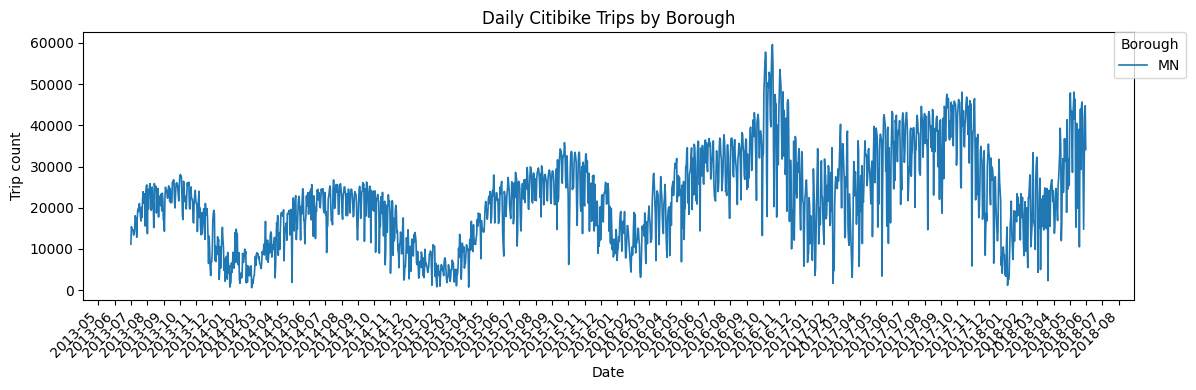

In [152]:
# 1) SQL with station_id included and no premature aggregation
bq_sql = """
WITH trips AS (
  SELECT
    t.start_station_id AS station_id,
    DATE(t.starttime)  AS trip_date
  FROM `bigquery-public-data.new_york_citibike.citibike_trips`   t
  JOIN `bigquery-public-data.new_york_citibike.citibike_stations` s
    ON t.start_station_name = s.name
  WHERE t.start_station_name IS NOT NULL
),
daily AS (
  SELECT
    station_id,
    trip_date,
    COUNT(*) AS trip_count
  FROM trips
  GROUP BY station_id, trip_date
),
cut AS (
  SELECT
    APPROX_QUANTILES(trip_count, 100)[OFFSET(33)] AS p33,
    APPROX_QUANTILES(trip_count, 100)[OFFSET(66)] AS p66
  FROM daily
)
SELECT
  station_id,
  trip_date,
  trip_count,
  CASE
    WHEN trip_count <= c.p33 THEN 'Low'
    WHEN trip_count <= c.p66 THEN 'Medium'
    ELSE 'High'
  END AS demand_category
FROM daily d
CROSS JOIN cut c
"""
bq_df = client.query(bq_sql).result().to_dataframe()

# ────────────────────────────────────────────────────────────────
# 2)  Local CSVs — same schema as citibike_trips
#     • folder:  ~/Downloads/missing_data
#     • gender: 0→unknown, 1→male, 2→female
# ────────────────────────────────────────────────────────────────
data_dir  = Path(tsv_path).expanduser().resolve().parent   # <‑‑ folder for both TSV + CSV
csv_files = list(data_dir.glob("*.csv"))                   # pick up every *.csv inside

csv_df_list = []
for fp in csv_files:
    print(fp)
    df = pd.read_csv(fp, parse_dates=["Start Time", "Stop Time"], low_memory=False)

    df = (
        df.assign(
            station_id=df["Start Station ID"].astype("Int64"),
            trip_date=df["Start Time"].dt.date,
            gender=df["Gender"].astype("string")
        )
        .loc[:, ["station_id", "trip_date", "gender"]]
    )

    df["gender"] = (
        df["gender"]
          .map({0: "unknown", 1: "male", 2: "female"})
          .fillna("unknown")
          .astype("string")
    )

    daily = (
        df.groupby(["station_id", "trip_date"])
          .size()
          .reset_index(name="trip_count")
    )

    csv_df_list.append(daily)

csv_df = (
    pd.concat(csv_df_list, ignore_index=True)
      .assign(src="local_csv")
)

# apply the same demand buckets used for BQ data
p33, p66 = csv_df["trip_count"].quantile([.33, .66])
csv_df["demand_category"] = pd.cut(
    csv_df["trip_count"],
    bins=[-float("inf"), p33, p66, float("inf")],
    labels=["Low", "Medium", "High"],
    right=True,
)

# ────────────────────────────────────────────────────────────────
# 3)  Stack BigQuery + CSV data, continue as before
# ────────────────────────────────────────────────────────────────
results = pd.concat([bq_df, csv_df], ignore_index=True)

# ────────────────────────────────────────────────────────────────
# 2) Read TSV (station_id as STRING)
# ────────────────────────────────────────────────────────────────
stations_boro = (
    pd.read_csv(tsv_path, sep="\t", dtype={'station_id': int})
      .loc[:, ['station_id', 'boro']]
      .drop_duplicates()
)

# ────────────────────────────────────────────────────────────────
# 3) Merge
# ────────────────────────────────────────────────────────────────
results['station_id'] = results['station_id'].astype(int)
merged = results.merge(stations_boro, on='station_id', how='left')

# quick sanity: any missing boroughs?
missing_pct = merged['boro'].isna().mean() * 100
print(f"Missing borough label for {missing_pct:.2f}% of station‑days")

# ────────────────────────────────────────────────────────────────
# 4) Aggregate trips by borough × day
# ────────────────────────────────────────────────────────────────
boro_daily = (
    merged
      .dropna(subset=['boro'])          # keep only labelled stations
      .groupby(['trip_date', 'boro'])['trip_count']
      .sum()
      .reset_index()
)

# pivot to wide for easy plotting
wide = (
    boro_daily
      .pivot(index='trip_date', columns='boro', values='trip_count')
      .fillna(0)
      .sort_index()
)

# ────────────────────────────────────────────────────────────────
# 5) Time‑series visualization
# ────────────────────────────────────────────────────────────────
plt.figure(figsize=(12,4))
wide['MN'].plot(ax=plt.gca(), linewidth=1.2)

plt.title("Daily Citibike Trips by Borough")
plt.ylabel("Trip count")
plt.xlabel("Date")

# nicer x‑axis ticks every 1 month
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y‑%m'))
plt.xticks(rotation=45, ha='right')

plt.legend(title='Borough', bbox_to_anchor=(1.05,1), borderaxespad=0)
plt.tight_layout()
plt.show()



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1965: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


/Users/oscartran/Peek/201610-citibike-tripdata_1.csv
/Users/oscartran/Peek/201703-citibike-tripdata.csv_1.csv
/Users/oscartran/Peek/201610-citibike-tripdata_2.csv
/Users/oscartran/Peek/201702-citibike-tripdata.csv_1.csv
/Users/oscartran/Peek/201611-citibike-tripdata_2.csv
/Users/oscartran/Peek/201701-citibike-tripdata.csv_1.csv
/Users/oscartran/Peek/201611-citibike-tripdata_1.csv
/Users/oscartran/Peek/201612-citibike-tripdata_1.csv
Missing borough label for 0.00% of station‑days
First date: 2013-07-01  —  Last date: 2018-05-31  (1,796 daily points)
Train points: 235,  Test points: 22
Hold‑out MAPE: 46.23%
Hold‑out MAPE (gap‑aware): 46.23%


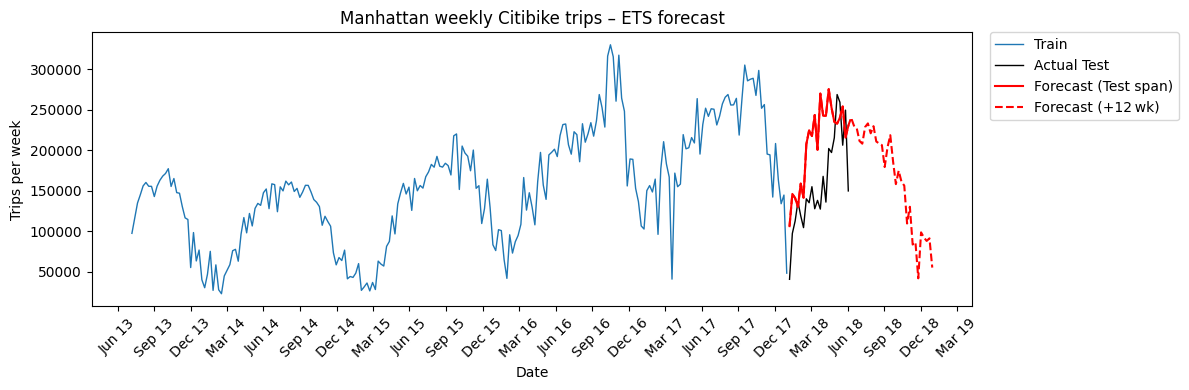

In [153]:
# 1) SQL with station_id included and no premature aggregation
bq_sql = """
WITH trips AS (
  SELECT
    t.start_station_id AS station_id,
    DATE(t.starttime)  AS trip_date
  FROM `bigquery-public-data.new_york_citibike.citibike_trips`   t
  JOIN `bigquery-public-data.new_york_citibike.citibike_stations` s
    ON t.start_station_name = s.name
  WHERE t.start_station_name IS NOT NULL
),
daily AS (
  SELECT
    station_id,
    trip_date,
    COUNT(*) AS trip_count
  FROM trips
  GROUP BY station_id, trip_date
),
cut AS (
  SELECT
    APPROX_QUANTILES(trip_count, 100)[OFFSET(33)] AS p33,
    APPROX_QUANTILES(trip_count, 100)[OFFSET(66)] AS p66
  FROM daily
)
SELECT
  station_id,
  trip_date,
  trip_count,
  CASE
    WHEN trip_count <= c.p33 THEN 'Low'
    WHEN trip_count <= c.p66 THEN 'Medium'
    ELSE 'High'
  END AS demand_category
FROM daily d
CROSS JOIN cut c
"""
bq_df = client.query(bq_sql).result().to_dataframe()

# ────────────────────────────────────────────────────────────────
# 2)  Local CSVs — same schema as citibike_trips
#     • folder:  ~/Downloads/missing_data
#     • gender: 0→unknown, 1→male, 2→female
# ────────────────────────────────────────────────────────────────
data_dir  = Path(tsv_path).expanduser().resolve().parent   # <‑‑ folder for both TSV + CSV
csv_files = list(data_dir.glob("*.csv"))                   # pick up every *.csv inside

csv_df_list = []
for fp in csv_files:
    print(fp)
    df = pd.read_csv(fp, parse_dates=["Start Time", "Stop Time"], low_memory=False)

    df = (
        df.assign(
            station_id=df["Start Station ID"].astype("Int64"),
            trip_date=df["Start Time"].dt.date,
            gender=df["Gender"].astype("string")
        )
        .loc[:, ["station_id", "trip_date", "gender"]]
    )

    df["gender"] = (
        df["gender"]
          .map({0: "unknown", 1: "male", 2: "female"})
          .fillna("unknown")
          .astype("string")
    )

    daily = (
        df.groupby(["station_id", "trip_date"])
          .size()
          .reset_index(name="trip_count")
    )

    csv_df_list.append(daily)

csv_df = (
    pd.concat(csv_df_list, ignore_index=True)
      .assign(src="local_csv")
)

# apply the same demand buckets used for BQ data
p33, p66 = csv_df["trip_count"].quantile([.33, .66])
csv_df["demand_category"] = pd.cut(
    csv_df["trip_count"],
    bins=[-float("inf"), p33, p66, float("inf")],
    labels=["Low", "Medium", "High"],
    right=True,
)

# ────────────────────────────────────────────────────────────────
# 3)  Stack BigQuery + CSV data, continue as before
# ────────────────────────────────────────────────────────────────
results = pd.concat([bq_df, csv_df], ignore_index=True)

# ────────────────────────────────────────────────────────────────
# 2) Read TSV (station_id as STRING)
# ────────────────────────────────────────────────────────────────
stations_boro = (
    pd.read_csv(tsv_path, sep="\t", dtype={'station_id': int})
      .loc[:, ['station_id', 'boro']]
      .drop_duplicates()
)

# ────────────────────────────────────────────────────────────────
# 3) Merge
# ────────────────────────────────────────────────────────────────
results['station_id'] = results['station_id'].astype(int)
merged = results.merge(stations_boro, on='station_id', how='left')

# quick sanity: any missing boroughs?
missing_pct = merged['boro'].isna().mean() * 100
print(f"Missing borough label for {missing_pct:.2f}% of station‑days")

# ────────────────────────────────────────────────────────────────
# 4) Aggregate trips by borough × day
# ────────────────────────────────────────────────────────────────
boro_daily = (
    merged
      .dropna(subset=['boro'])          # keep only labelled stations
      .groupby(['trip_date', 'boro'])['trip_count']
      .sum()
      .reset_index()
)

# pivot to wide for easy plotting
wide = (
    boro_daily
      .pivot(index='trip_date', columns='boro', values='trip_count')
      .fillna(0)
      .sort_index()
)

# ────────────────────────────────────────────────────────────────
# 1) extract MN series  (use the `wide` DataFrame created earlier)
# ────────────────────────────────────────────────────────────────
mn_daily = (
    wide['MN']                 # Series, index = date
        .asfreq('D')           # force explicit daily index
        .fillna(0)             # Citibike rarely has NA, but be safe
)

# quick sanity
print(f"First date: {mn_daily.index.min().date()}  —  "
      f"Last date: {mn_daily.index.max().date()}  "
      f"({len(mn_daily):,} daily points)")

# ────────────────────────────────────────────────────────────────
# 2) aggregate to weekly totals  (Saturday‑to‑Friday by default)
#    -> smoother, seasonality period = 52 weeks
# ────────────────────────────────────────────────────────────────
mn_weekly = mn_daily.resample('W').sum()

# ────────────────────────────────────────────────────────────────
# 3) simple train / test split
#    use everything up to 2023‑12‑31 for training, forecast 2024+
# ────────────────────────────────────────────────────────────────
split_date = '2018-01-01'
train = mn_weekly.loc[: split_date]
test  = mn_weekly.loc[split_date :]

print(f"Train points: {len(train)},  Test points: {len(test)}")

# ────────────────────────────────────────────────────────────────
# 4) fit ETS (additive trend, additive weekly seasonality)
#    weekly series → seasonality period = 52
# ────────────────────────────────────────────────────────────────
model = ExponentialSmoothing(
            train,
            trend='add',
            seasonal='add',
            seasonal_periods=52,
            initialization_method='estimated'
        ).fit(optimized=True)

ets = ETSModel(
        train,
        trend='add',
        seasonal='add',
        seasonal_periods=52,
        damped_trend=False,
        missing='drop'          # <<< key line: drops NaNs internally
)
fit = ets.fit()

# ────────────────────────────────────────────────────────────────
# 5) forecast the test span + 12 future weeks
# ────────────────────────────────────────────────────────────────
test_non_na = test.dropna()
fh_test   = len(test_non_na)
fh_future = 52          # change if you want a different horizon

pred_test   = fit.forecast(fh_test).rename('forecast_test')
pred_future = fit.forecast(fh_future).rename('forecast_future')

# evaluation on the hold‑out period
mape = mean_absolute_percentage_error(test, pred_test) * 100
print(f"Hold‑out MAPE: {mape:.2f}%")

# evaluate only where we truly have both y_true and y_pred
if fh_test > 0:
    mape = mean_absolute_percentage_error(test_non_na, pred_test) * 100
    print(f"Hold‑out MAPE (gap‑aware): {mape:.2f}%")
else:
    print("No non‑missing weeks in the test slice; skipping MAPE.")

# ────────────────────────────────────────────────────────────────
# 6) plot
# ────────────────────────────────────────────────────────────────
plt.figure(figsize=(12,4))
plt.plot(train,  label='Train',  linewidth=1)
plt.plot(test,   label='Actual Test', color='black', linewidth=1)
plt.plot(pred_test,   label='Forecast (Test span)', color='red')
plt.plot(pred_future, label='Forecast (+12 wk)',   color='red', linestyle='--')

plt.title("Manhattan weekly Citibike trips – ETS forecast")
plt.ylabel("Trips per week")
plt.xlabel("Date")

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))
plt.xticks(rotation=45)

plt.legend(bbox_to_anchor=(1.02,1), borderaxespad=0)
plt.tight_layout()
plt.show()



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1965: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


/Users/oscartran/Peek/201610-citibike-tripdata_1.csv
/Users/oscartran/Peek/201703-citibike-tripdata.csv_1.csv
/Users/oscartran/Peek/201610-citibike-tripdata_2.csv
/Users/oscartran/Peek/201702-citibike-tripdata.csv_1.csv
/Users/oscartran/Peek/201611-citibike-tripdata_2.csv
/Users/oscartran/Peek/201701-citibike-tripdata.csv_1.csv
/Users/oscartran/Peek/201611-citibike-tripdata_1.csv
/Users/oscartran/Peek/201612-citibike-tripdata_1.csv
Missing borough label for 0.00% of station‑days
First date: 2013-07-01  —  Last date: 2018-05-31  (1,796 daily points)
Train points: 235,  Test points: 22


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Hold‑out MAPE: 22.36%


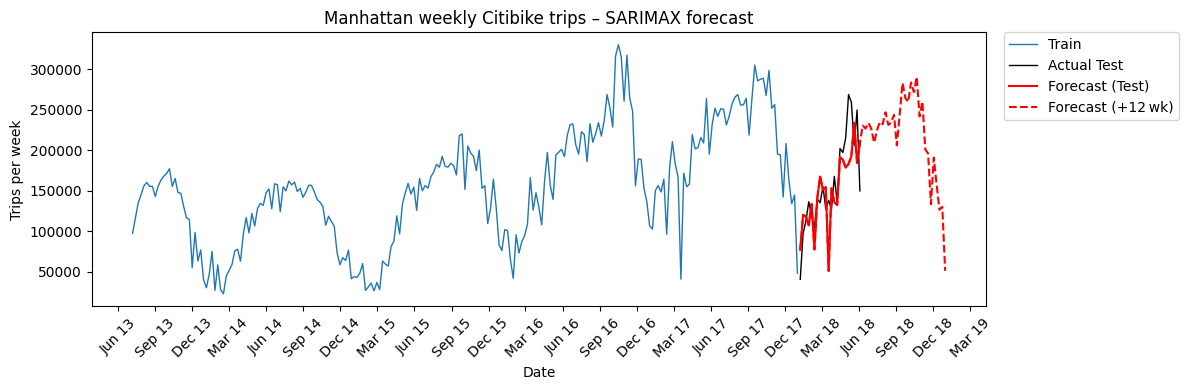

In [156]:
# 1) SQL with station_id included and no premature aggregation
bq_sql = """
WITH trips AS (
  SELECT
    t.start_station_id AS station_id,
    DATE(t.starttime)  AS trip_date
  FROM `bigquery-public-data.new_york_citibike.citibike_trips`   t
  JOIN `bigquery-public-data.new_york_citibike.citibike_stations` s
    ON t.start_station_name = s.name
  WHERE t.start_station_name IS NOT NULL
),
daily AS (
  SELECT
    station_id,
    trip_date,
    COUNT(*) AS trip_count
  FROM trips
  GROUP BY station_id, trip_date
),
cut AS (
  SELECT
    APPROX_QUANTILES(trip_count, 100)[OFFSET(33)] AS p33,
    APPROX_QUANTILES(trip_count, 100)[OFFSET(66)] AS p66
  FROM daily
)
SELECT
  station_id,
  trip_date,
  trip_count,
  CASE
    WHEN trip_count <= c.p33 THEN 'Low'
    WHEN trip_count <= c.p66 THEN 'Medium'
    ELSE 'High'
  END AS demand_category
FROM daily d
CROSS JOIN cut c
"""
bq_df = client.query(bq_sql).result().to_dataframe()

# ────────────────────────────────────────────────────────────────
# 2)  Local CSVs — same schema as citibike_trips
#     • folder:  ~/Downloads/missing_data
#     • gender: 0→unknown, 1→male, 2→female
# ────────────────────────────────────────────────────────────────
data_dir  = Path(tsv_path).expanduser().resolve().parent   # <‑‑ folder for both TSV + CSV
csv_files = list(data_dir.glob("*.csv"))                   # pick up every *.csv inside

csv_df_list = []
for fp in csv_files:
    print(fp)
    df = pd.read_csv(fp, parse_dates=["Start Time", "Stop Time"], low_memory=False)

    df = (
        df.assign(
            station_id=df["Start Station ID"].astype("Int64"),
            trip_date=df["Start Time"].dt.date,
            gender=df["Gender"].astype("string")
        )
        .loc[:, ["station_id", "trip_date", "gender"]]
    )

    df["gender"] = (
        df["gender"]
          .map({0: "unknown", 1: "male", 2: "female"})
          .fillna("unknown")
          .astype("string")
    )

    daily = (
        df.groupby(["station_id", "trip_date"])
          .size()
          .reset_index(name="trip_count")
    )

    csv_df_list.append(daily)

csv_df = (
    pd.concat(csv_df_list, ignore_index=True)
      .assign(src="local_csv")
)

# apply the same demand buckets used for BQ data
p33, p66 = csv_df["trip_count"].quantile([.33, .66])
csv_df["demand_category"] = pd.cut(
    csv_df["trip_count"],
    bins=[-float("inf"), p33, p66, float("inf")],
    labels=["Low", "Medium", "High"],
    right=True,
)

# ────────────────────────────────────────────────────────────────
# 3)  Stack BigQuery + CSV data, continue as before
# ────────────────────────────────────────────────────────────────
results = pd.concat([bq_df, csv_df], ignore_index=True)

# ────────────────────────────────────────────────────────────────
# 2) Read TSV (station_id as STRING)
# ────────────────────────────────────────────────────────────────
stations_boro = (
    pd.read_csv(tsv_path, sep="\t", dtype={'station_id': int})
      .loc[:, ['station_id', 'boro']]
      .drop_duplicates()
)

# ────────────────────────────────────────────────────────────────
# 3) Merge
# ────────────────────────────────────────────────────────────────
results['station_id'] = results['station_id'].astype(int)
merged = results.merge(stations_boro, on='station_id', how='left')

# quick sanity: any missing boroughs?
missing_pct = merged['boro'].isna().mean() * 100
print(f"Missing borough label for {missing_pct:.2f}% of station‑days")

# ────────────────────────────────────────────────────────────────
# 4) Aggregate trips by borough × day
# ────────────────────────────────────────────────────────────────
boro_daily = (
    merged
      .dropna(subset=['boro'])          # keep only labelled stations
      .groupby(['trip_date', 'boro'])['trip_count']
      .sum()
      .reset_index()
)

# pivot to wide for easy plotting
wide = (
    boro_daily
      .pivot(index='trip_date', columns='boro', values='trip_count')
      .fillna(0)
      .sort_index()
)

# ────────────────────────────────────────────────────────────────
# 1) extract MN series  (use the `wide` DataFrame created earlier)
# ────────────────────────────────────────────────────────────────
mn_daily = (
    wide['MN']                 # Series, index = date
        .asfreq('D')           # force explicit daily index
        .fillna(0)             # Citibike rarely has NA, but be safe
)

# quick sanity
print(f"First date: {mn_daily.index.min().date()}  —  "
      f"Last date: {mn_daily.index.max().date()}  "
      f"({len(mn_daily):,} daily points)")

# ────────────────────────────────────────────────────────────────
# 2) aggregate to weekly totals  (Saturday‑to‑Friday by default)
#    -> smoother, seasonality period = 52 weeks
# ────────────────────────────────────────────────────────────────
mn_weekly = mn_daily.resample('W').sum()

# ────────────────────────────────────────────────────────────────
# 3) simple train / test split
#    use everything up to 2023‑12‑31 for training, forecast 2024+
# ────────────────────────────────────────────────────────────────
split_date = '2018-01-01'
train = mn_weekly.loc[: split_date]
test  = mn_weekly.loc[split_date :]

print(f"Train points: {len(train)},  Test points: {len(test)}")

# ────────────────────────────────────────────────────────────────
# 4) fit ETS (additive trend, additive weekly seasonality)
#    weekly series → seasonality period = 52
# ────────────────────────────────────────────────────────────────
sarimax_model = SARIMAX(
    train,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 52),
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarimax_fit = sarimax_model.fit(disp=False)

# ────────────────────────────────────────────────────────────────
# 5) forecast the test span + future weeks
# ────────────────────────────────────────────────────────────────
# forecast the same length as your test slice
fh_test   = len(test.dropna())
fh_future = 52

# For the test period, align predictions to your test index
pred_test = sarimax_fit.get_prediction(
    start=test.index[0],
    end=test.index[0] + pd.offsets.Week(fh_test-1),
    dynamic=False
).predicted_mean.rename('forecast_test')

# For the future horizon, forecast forward
pred_future = sarimax_fit.get_forecast(
    steps=fh_future
).predicted_mean.rename('forecast_future')

# ────────────────────────────────────────────────────────────────
# 6) evaluate with MAPE
# ────────────────────────────────────────────────────────────────
test_non_na = test.dropna()
mape_test   = mean_absolute_percentage_error(test_non_na, pred_test.loc[test_non_na.index]) * 100
print(f"Hold‑out MAPE: {mape_test:.2f}%")

# ────────────────────────────────────────────────────────────────
# 7) plot
# ────────────────────────────────────────────────────────────────
plt.figure(figsize=(12,4))
plt.plot(train,             label='Train',             linewidth=1)
plt.plot(test,              label='Actual Test', color='black', linewidth=1)
plt.plot(pred_test,         label='Forecast (Test)',    color='red')
plt.plot(pred_future,       label='Forecast (+12 wk)',  color='red', linestyle='--')

plt.title("Manhattan weekly Citibike trips – SARIMAX forecast")
plt.ylabel("Trips per week")
plt.xlabel("Date")

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))
plt.xticks(rotation=45)

plt.legend(bbox_to_anchor=(1.02,1), borderaxespad=0)
plt.tight_layout()
plt.show()



In [168]:
# 1) SQL with station_id included and no premature aggregation
bq_sql = """
WITH daily AS (
  SELECT
    t.start_station_id            AS station_id,
    t.start_station_name          AS station_name,
    DATE(t.starttime)             AS trip_date,
    t.usertype                    AS user_type,
    COUNT(*)                      AS trip_count
  FROM `bigquery-public-data.new_york_citibike.citibike_trips` t
  GROUP BY 1,2,3,4
),

cut AS (
  SELECT
    APPROX_QUANTILES(trip_count, 100)[SAFE_OFFSET(33)] AS p33,
    APPROX_QUANTILES(trip_count, 100)[SAFE_OFFSET(66)] AS p66
  FROM daily
)

SELECT
  d.*,
  CASE
    WHEN trip_count <= c.p33 THEN 'Low'
    WHEN trip_count <= c.p66 THEN 'Medium'
    ELSE 'High'
  END AS demand_category
FROM daily d
CROSS JOIN cut c
"""
# Storage API -> much faster download
bq_df = client.query(bq_sql).result().to_dataframe(bqstorage_client=True)

# ────────────────────────────────────────────────────────────────
# 2)  Local CSVs — same schema as citibike_trips
#     • folder:  ~/Downloads/missing_data
#     • gender: 0→unknown, 1→male, 2→female
# ────────────────────────────────────────────────────────────────
data_dir  = Path(tsv_path).expanduser().resolve().parent   # <‑‑ folder for both TSV + CSV
csv_files = list(data_dir.glob("*.csv"))                   # pick up every *.csv inside

csv_df_list = []
for fp in csv_files:
    df = pd.read_csv(fp, parse_dates=["Start Time", "Stop Time"], low_memory=False)


    df = (
        df.assign(
            station_id=df["Start Station ID"].astype("Int64"),
            station_name=df["Start Station Name"].astype("string"),
            trip_date=df["Start Time"].dt.date,
            gender=df["Gender"].astype("string"),
            user_type=df["User Type"].astype("string"),
            birth_year=df["Birth Year"].astype("Int64")
            
        )
        .loc[:, ["station_id", "station_name", "trip_date", "gender", "user_type", "birth_year"]]
    )

    df["gender"] = (
        df["gender"]
          .map({0: "unknown", 1: "male", 2: "female"})
          .fillna("unknown")
          .astype("string")
    )

    daily = (
        df.groupby(["station_id", "station_name", "trip_date", "gender", "user_type", "birth_year"])
          .size()
          .reset_index(name="trip_count")
    )

    csv_df_list.append(daily)

csv_df = (
    pd.concat(csv_df_list, ignore_index=True)
      .assign(src="local_csv")
)

# apply the same demand buckets used for BQ data
p33, p66 = csv_df["trip_count"].quantile([.33, .66])
csv_df["demand_category"] = pd.cut(
    csv_df["trip_count"],
    bins=[-float("inf"), p33, p66, float("inf")],
    labels=["Low", "Medium", "High"],
    right=True,
)

# ────────────────────────────────────────────────────────────────
# 3)  Stack BigQuery + CSV data, continue as before
# ────────────────────────────────────────────────────────────────
results = pd.concat([bq_df, csv_df], ignore_index=True)

results['station_id'] = (
    pd.to_numeric(results['station_id'], errors='coerce')  # force strings → numbers
      .astype('Int64')                                     # nullable int dtype
)

# ────────────────────────────────────────────────────────────────
# 2) Read TSV (station_id as STRING)
# ────────────────────────────────────────────────────────────────
stations_boro = (
    pd.read_csv(tsv_path, sep="\t", dtype={'station_id': int})
      .loc[:, ['station_id', 'boro']]
      .drop_duplicates()
)

# ────────────────────────────────────────────────────────────────
# 3) Merge
# ────────────────────────────────────────────────────────────────
stations_boro['station_id'] = stations_boro['station_id'].astype('Int64')
merged = results.merge(stations_boro, on='station_id', how='left')

# ------------------------------------------------------------------
# A)  Pivot: station × user_type  ➜ every cell = total trips
# ------------------------------------------------------------------
station_user = (
    merged
      .groupby(['station_name', 'user_type'])['trip_count']
      .sum()
      .reset_index()
)

pivot = (
    station_user
      .pivot(index='station_name', columns='user_type', values='trip_count')
      .fillna(0)
      .sort_values(by='Subscriber', ascending=False)   # or any column
)

print(pivot.head(10))          # top 10 stations by Subscriber trips

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1965: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


/Users/oscartran/Peek/201610-citibike-tripdata_1.csv
Index(['Trip Duration', 'Start Time', 'Stop Time', 'Start Station ID',
       'Start Station Name', 'Start Station Latitude',
       'Start Station Longitude', 'End Station ID', 'End Station Name',
       'End Station Latitude', 'End Station Longitude', 'Bike ID', 'User Type',
       'Birth Year', 'Gender'],
      dtype='object')
/Users/oscartran/Peek/201703-citibike-tripdata.csv_1.csv
Index(['Trip Duration', 'Start Time', 'Stop Time', 'Start Station ID',
       'Start Station Name', 'Start Station Latitude',
       'Start Station Longitude', 'End Station ID', 'End Station Name',
       'End Station Latitude', 'End Station Longitude', 'Bike ID', 'User Type',
       'Birth Year', 'Gender'],
      dtype='object')
/Users/oscartran/Peek/201610-citibike-tripdata_2.csv
Index(['Trip Duration', 'Start Time', 'Stop Time', 'Start Station ID',
       'Start Station Name', 'Start Station Latitude',
       'Start Station Longitude', 'End Station 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1965: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(
/var/folders/nm/dc639mrx6s90bqg3vn0khw9c0000gn/T/ipykernel_11734/1390088943.py:52: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  trip_hour  = df["Start Time"].dt.floor('H'),
/var/folders/nm/dc639mrx6s90bqg3vn0khw9c0000gn/T/ipykernel_11734/1390088943.py:52: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  trip_hour  = df["Start Time"].dt.floor('H'),
/var/folders/nm/dc639mrx6s90bqg3vn0khw9c0000gn/T/ipykernel_11734/1390088943.py:52: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  trip_hour  = df["Start Time"].dt.floor('H'),
/var/folders/nm/dc639mrx6s90bqg3vn0khw9c0000gn/T/ipykernel_11734/1390088943.py:52: FutureWa

First hr: 2013-07-01 00:00:00  —  Last hr:  2018-05-31 23:00:00  (43,104 hourly points)


/var/folders/nm/dc639mrx6s90bqg3vn0khw9c0000gn/T/ipykernel_11734/1390088943.py:153: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  fc_idx = pd.date_range(start=mn_hourly.index.max()+pd.Timedelta(hours=1),


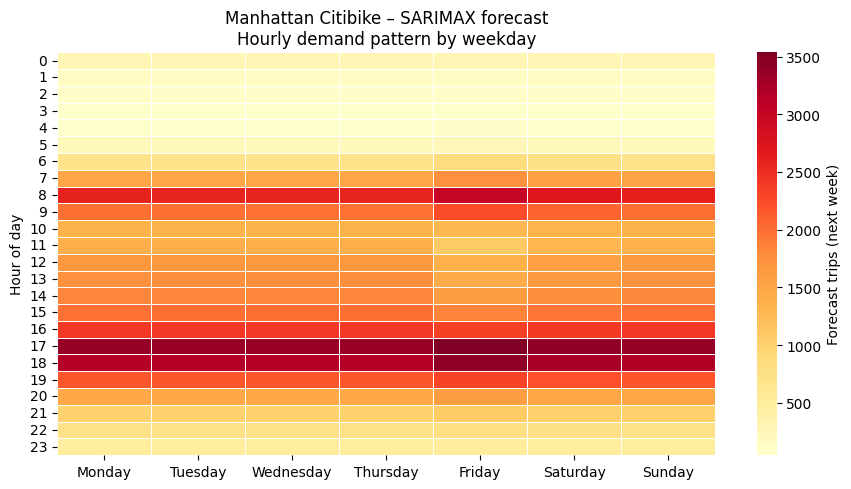

In [12]:
# ────────────────────────────────────────────────────────────────
# 1)  HOURLY SQL  (station_id kept, no premature aggregation)
# ────────────────────────────────────────────────────────────────
hourly_sql = """
WITH trips AS (
  SELECT
    t.start_station_id AS station_id,
    DATETIME_TRUNC(t.starttime, HOUR) AS trip_hour
  FROM `bigquery-public-data.new_york_citibike.citibike_trips`   t
  JOIN `bigquery-public-data.new_york_citibike.citibike_stations` s
    ON t.start_station_name = s.name
  WHERE t.start_station_name IS NOT NULL
),
hourly AS (
  SELECT
    station_id,
    trip_hour,
    COUNT(*) AS trip_count
  FROM trips
  GROUP BY station_id, trip_hour
)
SELECT * FROM hourly
"""

bq_df = (
    client.query(hourly_sql)
          .result()
          .to_dataframe()
          .assign(trip_hour=lambda x: pd.to_datetime(x['trip_hour']))
          .astype({'station_id': 'int'})
)

# ────────────────────────────────────────────────────────────────
# 2)  Local CSVs  → hourly counts
# ────────────────────────────────────────────────────────────────
csv_df_list = []
for fp in csv_files:
    df = pd.read_csv(fp, parse_dates=["Start Time", "Stop Time"], low_memory=False)

    df = (
        df.assign(
            station_id = df["Start Station ID"].astype("Int64"),
            trip_hour  = df["Start Time"].dt.floor('H'),
            gender     = df["Gender"].map({0: "unknown", 1: "male", 2: "female"})
        )[["station_id", "trip_hour"]]
    )

    hourly = (
        df.groupby(["station_id", "trip_hour"])
          .size()
          .reset_index(name="trip_count")
    )
    csv_df_list.append(hourly)

csv_df = pd.concat(csv_df_list, ignore_index=True)

# same p33 / p66 logic, but on hourly counts
p33, p66 = csv_df["trip_count"].quantile([.33, .66])
csv_df["demand_category"] = pd.cut(
    csv_df["trip_count"],
    bins=[-float("inf"), p33, p66, float("inf")],
    labels=["Low", "Medium", "High"],
)

# ────────────────────────────────────────────────────────────────
# 3)  Combine BQ + CSV and add borough
# ────────────────────────────────────────────────────────────────
results = pd.concat([bq_df, csv_df], ignore_index=True)

stations_boro = (
    pd.read_csv(tsv_path, sep="\t", dtype={'station_id': int})
      .loc[:, ['station_id', 'boro']]
      .drop_duplicates()
)

results['station_id'] = results['station_id'].astype(int)
merged = results.merge(stations_boro, on='station_id', how='left')

# ────────────────────────────────────────────────────────────────
# 4) Aggregate trips by borough × trip_hour
# ────────────────────────────────────────────────────────────────
boro_hourly = (
    merged
      .dropna(subset=['boro'])
      .groupby(['trip_hour', 'boro'])['trip_count']
      .sum()
      .reset_index()
)

wide = (
    boro_hourly
      .pivot(index='trip_hour', columns='boro', values='trip_count')
      .fillna(0)
      .sort_index()             # chronological
)

# ────────────────────────────────────────────────────────────────
# 1) Aggregate to hourly totals for Manhattan (MN)
# ────────────────────────────────────────────────────────────────
mn_hourly = (
    merged                         # (same merged DF you already have)
      .dropna(subset=['boro'])     # keep only labelled stations
      .loc[merged['boro'] == 'MN'] # Manhattan only
      .assign(trip_hour=pd.to_datetime(
              merged['trip_hour']).dt.floor('H'))  # ensure datetime @ hour
      .groupby('trip_hour')['trip_count']
      .sum()
      .asfreq('H')                 # explicit hourly index
      .fillna(0)
)

print(f"First hr: {mn_hourly.index.min()}  —  "
      f"Last hr:  {mn_hourly.index.max()}  "
      f"({len(mn_hourly):,} hourly points)")

# ────────────────────────────────────────────────────────────────
# 2) Train / test split  (end of 2023‑12‑31 23:00)
# ────────────────────────────────────────────────────────────────
cutoff = '2024-01-01 00:00:00'
train_h = mn_hourly.loc[: cutoff]
test_h  = mn_hourly.loc[cutoff :]

# ────────────────────────────────────────────────────────────────
# 3) Fit SARIMAX
#    • Regular ARIMA(1,0,1)
#    • Seasonal (24‑hour) differencing to remove daily cycle
#    • Another seasonal layer at 168 h (7×24) for weekly rhythm
# ────────────────────────────────────────────────────────────────
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarimax_h = SARIMAX(
    train_h,
    order=(1,0,1),            # simple ARMA
    seasonal_order=(1,1,1,24),# daily seasonality
    second_seasonal_order=(1,0,1,168),  # weekly seasonality (statsmodels ≥0.15)
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

# ────────────────────────────────────────────────────────────────
# 4) Forecast one full week (168 hours)
# ────────────────────────────────────────────────────────────────
steps  = 168
fc_idx = pd.date_range(start=mn_hourly.index.max()+pd.Timedelta(hours=1),
                       periods=steps, freq='H')
forecast_h = sarimax_h.get_forecast(steps=steps).predicted_mean
forecast_h.index = fc_idx        # align index explicitly

# ────────────────────────────────────────────────────────────────
# 5) Build weekday × hour matrix for the forecast horizon
# ────────────────────────────────────────────────────────────────
heat_df = (
    forecast_h.to_frame('trips')
        .assign(weekday=lambda x: x.index.day_name(),
                hour   = lambda x: x.index.hour)
        .pivot_table(index='hour', columns='weekday', values='trips')
        .reindex(index=range(24))                     # 0‑23 hrs
        .reindex(columns=['Monday','Tuesday','Wednesday',
                          'Thursday','Friday','Saturday','Sunday'])
)

# ────────────────────────────────────────────────────────────────
# 6) Visualise
# ────────────────────────────────────────────────────────────────
import seaborn as sns
plt.figure(figsize=(9,5))
sns.heatmap(
    heat_df,
    cmap='YlOrRd',
    linewidths=.5,
    cbar_kws={'label':'Forecast trips (next week)'}
)
plt.title('Manhattan Citibike – SARIMAX forecast\nHourly demand pattern by weekday')
plt.ylabel('Hour of day')
plt.xlabel('')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

